In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

In [4]:
class Layer(torch.nn.Module):
    def __init__(self, size_in, size_out, activation_func=torch.sigmoid):
        super(Layer, self).__init__()
        self.w = torch.nn.Parameter(torch.randn(size_in, size_out, requires_grad=True))
        self.b = torch.nn.Parameter(torch.randn(1, size_out, requires_grad=True))
        self.activation_func = activation_func
        
    def forward(self, x):
        return self.activation_func(x @ self.w + self.b)
        
    
    def predict(self, x):
        # do predict with the data without the dropout
        return self.activation_func(x @ self.w + self.b)

In [136]:
class LSTM(torch.nn.Module):
    def __init__(self, size_in, size_out, size_short, size_long):
        super(LSTM,self).__init__()
        self.layer_0 = Layer(size_in + size_short, size_long)
        self.layer_1 = Layer(size_in + size_short, size_long)
        self.layer_2 = Layer(size_in + size_short, size_long, activation_func = torch.tanh)
        self.layer_3 = Layer(size_in + size_short, size_short)
        self.layer_4 = Layer(size_long, size_short, activation_func = torch.tanh)
        self.layer_out = Layer(size_short, size_out, lambda x: x)
        self.size_short = size_short
        self.size_long = size_long
        
    def forward(self, x):
        short_mem = torch.zeros(1, self.size_short)
        long_mem = torch.zeros(1, self.size_long)
        out = []
        for i in range(x.shape[0]):
            z = torch.cat([x[[i],:], short_mem], dim=1)
            long_mem = self.layer_0.forward(z) * long_mem + self.layer_1.forward(z) * self.layer_2.forward(z)
            short_mem = self.layer_3.forward(z) * self.layer_4.forward(long_mem)
            out.append(self.layer_out.forward(short_mem))
        out = torch.cat(out, dim=0)
        return out
    
    def generate(self, start, iteration):
        short_mem = torch.randn(1, self.size_short)
        long_mem = torch.randn(1, self.size_long)
        out = [start]
        for i in range(iteration):
            z = torch.cat([out[i], short_mem], dim=1)
            long_mem = self.layer_0.forward(z) * long_mem + self.layer_1.forward(z) * self.layer_2.forward(z)
            short_mem = self.layer_3.forward(z) * self.layer_4.forward(long_mem)
            out.append(self.layer_out.forward(short_mem))
            if Decode(out[-1]) == '|' or len(Decode(out[-1])) > 30:
                break
            
        out = torch.cat(out, dim=0)
        return out
    

In [137]:
df = pd.read_csv('dinosaurs.csv', header=None)
df.columns = ['name']

In [138]:
a = ord('a')

def Encode(name):
    name = ''.join(['{', name.lower(), '|'])
    out = []
    for char in name:
        char_encoded = torch.zeros((1, 28))
        char_encoded[0, ord(char)-a] = 1
        out.append(char_encoded)
    return torch.cat(out, dim = 0)

def Decode(tensor):
    ords = torch.argmax(tensor, dim=1)
    out = []
    for i in ords:
        out.append(chr(i + a))
    return ''.join(out)

In [139]:
df_encoded = df.name.apply(Encode)

In [140]:
model = LSTM(28, 28, 14, 14)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_func = torch.nn.CrossEntropyLoss()
losses = []

 Iteration: 9999 | loss is 1.3258016109466553

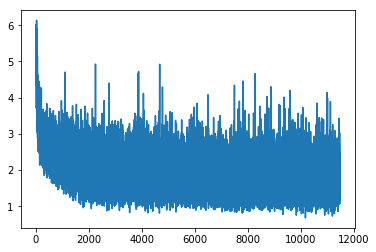

In [143]:
iterations = 10000

for i in range(iterations):
    y = df_encoded.sample().values[0]
    y_hat = model.forward(y)
    loss = loss_func(y_hat[:-1], torch.argmax(y[1:], dim = 1))
    loss.backward()
    opt.step()
    opt.zero_grad()
    losses.append(loss.detach())
    print('\r Iteration: {} | loss is {}'.format(i, loss.detach()), end='')
plt.plot(losses)


In [151]:
Decode(model.generate(Encode('')[[0], :], 100))

'{urrxpinppinpnuurojuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuurpusonpnj{|'